### Importing Libraries

In [ ]:
# Importing required packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import nltk
import re
import string
#from itertools import chain
from collections import Counter
from wordcloud import WordCloud
import gensim
from scipy.stats.morestats import yeojohnson_normplot


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import confusion_matrix


<ipython-input-240-e7678bcb995a>:17: DeprecationWarning:

Please use `yeojohnson_normplot` from the `scipy.stats` namespace, the `scipy.stats.morestats` namespace is deprecated.



In [ ]:
# All required import downloads for error free execution

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Loading data and validating

In [ ]:

real_data = pd.read_csv('https://raw.githubusercontent.com/Dheeraj0725/Fake-news-detection/main/Dataset/True.csv')
fake_data = pd.read_csv('https://raw.githubusercontent.com/Dheeraj0725/Fake-news-detection/main/Dataset/Fake.csv')

In [ ]:

real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
real_data.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
fake_data.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

### Exploratory Data Analysis on Datasets

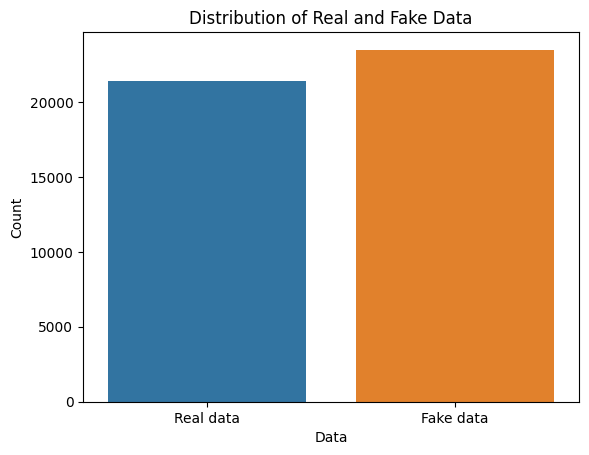

In [ ]:
#representing distribution of fake and real data

real_count=len(real_data)
fake_count=len(fake_data)
sns.barplot(x=['Real data', 'Fake data'], y=[real_count, fake_count])
plt.xlabel('Data')
plt.ylabel('Count')
plt.title('Distribution of Real and Fake Data')

# Show the plot
plt.show()

In [ ]:
real_data.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
real_data['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

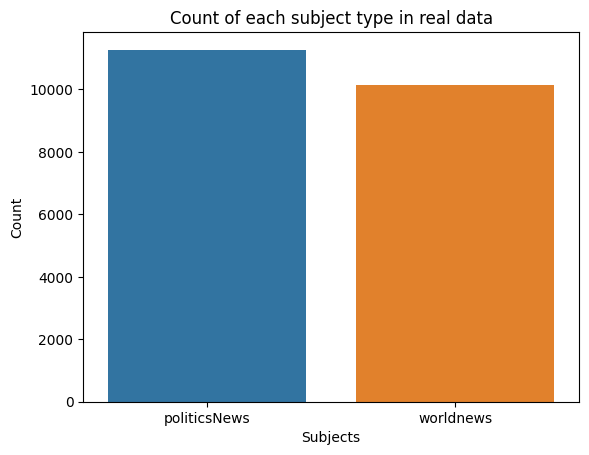

In [ ]:
#Different types of subjects in the real dataset
subject_types_data=real_data['subject'].value_counts()
sns.barplot(x=subject_types_data.index, y=subject_types_data.values)

# Add labels and title
plt.xlabel('Subjects')
plt.ylabel('Count')
plt.title('Count of each subject type in real data')

# Show the plot
plt.show()

In [ ]:
#timelines of the gathered real data

real_data['date'] = pd.to_datetime(real_data['date'],errors='coerce')

# Get earliest and latest dates in the 'date' column
earliest_date = real_data['date'].min().strftime('%Y-%m-%d')
latest_date = real_data['date'].max().strftime('%Y-%m-%d')

print('Gathered real data is in the time range of:', earliest_date, 'to', latest_date)

Gathered real data is in the time range of: 2016-01-13 to 2017-12-31


In [ ]:
fake_data.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake_data['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

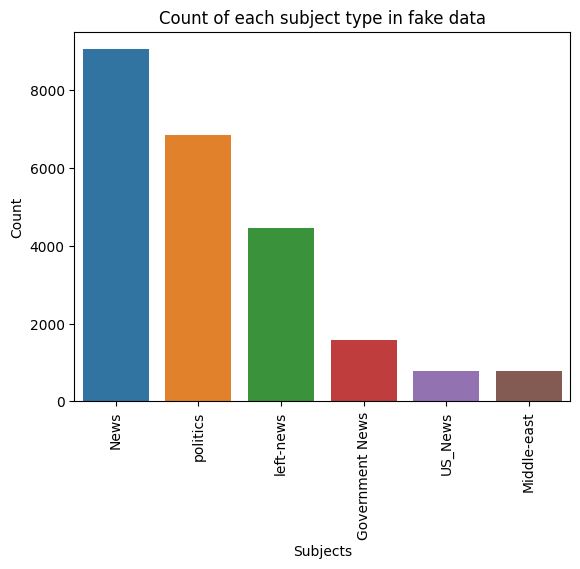

In [ ]:
#Different types of subjects in the fake dataset
subject_types_data=fake_data['subject'].value_counts()
sns.barplot(x=subject_types_data.index, y=subject_types_data.values)

# Add labels and title
plt.xlabel('Subjects')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Count of each subject type in fake data')

# Show the plot
plt.show()

In [ ]:
#timelines of the gathered fake data

fake_data['date'] = pd.to_datetime(fake_data['date'],errors='coerce')

# Get earliest and latest dates in the 'date' column
earliest_date = fake_data['date'].min().strftime('%Y-%m-%d')
latest_date = fake_data['date'].max().strftime('%Y-%m-%d')

print('Gathered fake data is in the time range of:', earliest_date, 'to', latest_date)

Gathered fake data is in the time range of: 2015-03-31 to 2018-02-19


In [ ]:
real_data['type'] = 1
fake_data['type'] = 0

In [ ]:
real_data['text'] = real_data['title'] + " " + real_data['text']
fake_data['text'] = fake_data['title'] + " " + fake_data['text']

In [ ]:
real_data['text'] = real_data['text'].apply(lambda x: str(x).lower())
fake_data['text'] = fake_data['text'].apply(lambda x: str(x).lower())

### Preprocessing datasets

In [ ]:
# Removing all stop words from the text data. Punctuation and special character removal

stop_words = set(stopwords.words('english'))
to_remove = ['•', '!', '"', '#', '”', '“', '$', '%', '&', "'", '–', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '…']
stop_words.update(to_remove)
print('Number of stopwords:', len(stop_words))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub('\[[^]]*\]', '', text)
    text = (" ").join([word for word in text.split() if not word in stop_words])
    text = "".join([char for char in text if not char in to_remove])
    return text

Number of stopwords: 226


In [ ]:
real_data['text'] = real_data['text'].apply(preprocess_text)
fake_data['text'] = fake_data['text'].apply(preprocess_text)

In [ ]:
combined_data = pd.concat([real_data[['text', 'type']], fake_data[['text', 'type']]], ignore_index=True)
combined_data

,text,type
0,us budget fight looms republicans flip fiscal ...,1
1,us military accept transgender recruits monday...,1
2,senior us republican senator let mr mueller jo...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump wants postal service charge much more am...,1
...,...,...
44893,mcpain john mccain furious iran treated us sai...,0
44894,justice yahoo settles email privacy classactio...,0
44895,sunnistan us allied ‘safe zone’ plan take terr...,0
44896,blow million al jazeera america finally calls...,0


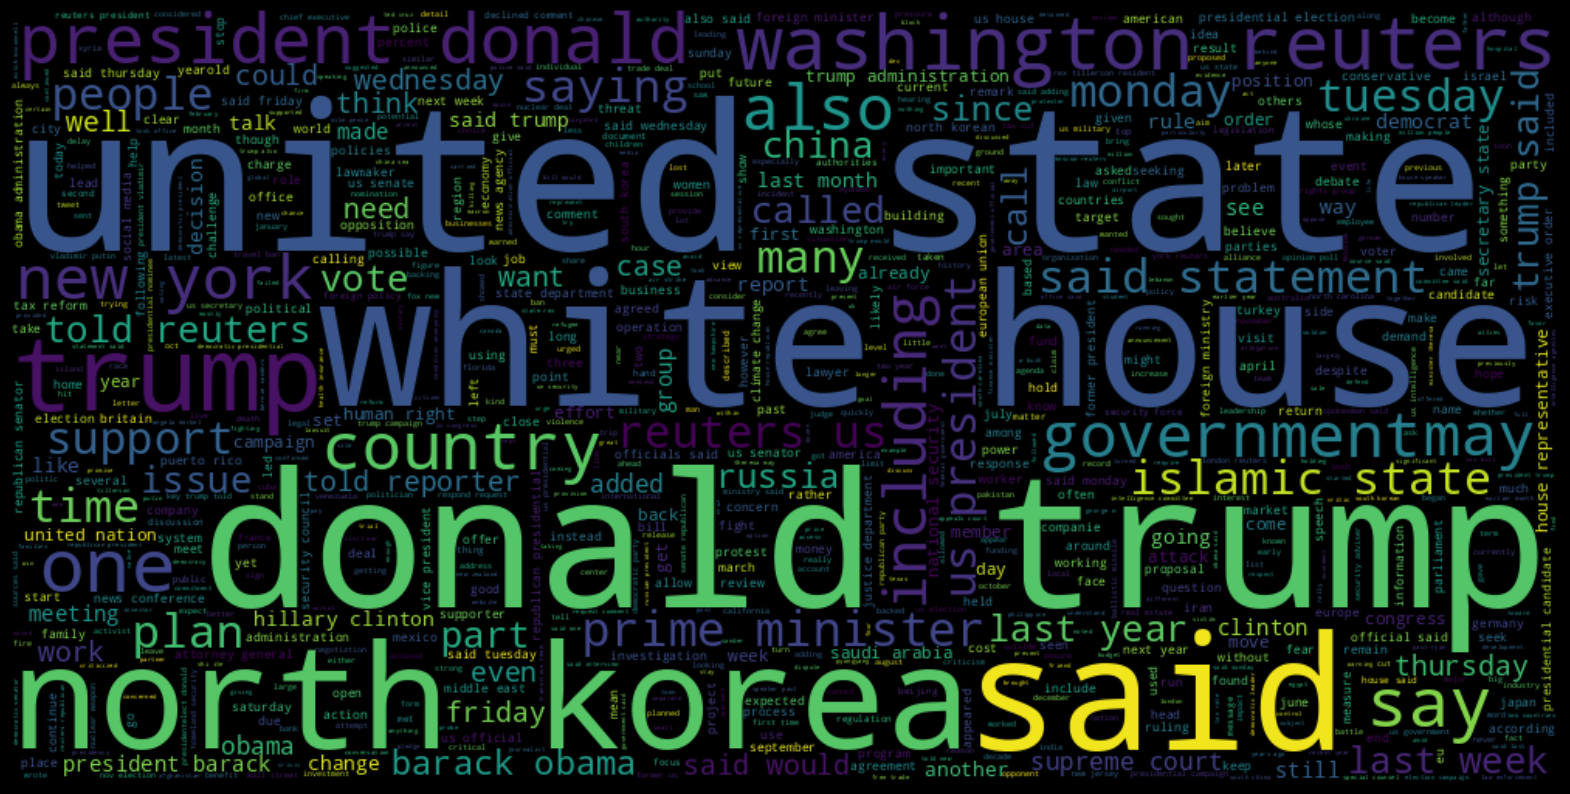

In [ ]:

text = " ".join(combined_data[combined_data.type == 1].text)

wc = WordCloud(max_words=1500, width=1000, height=500, stopwords=set(stopwords.words('english')))
wc.generate(text)

plt.figure(figsize=(20, 20), facecolor='k')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


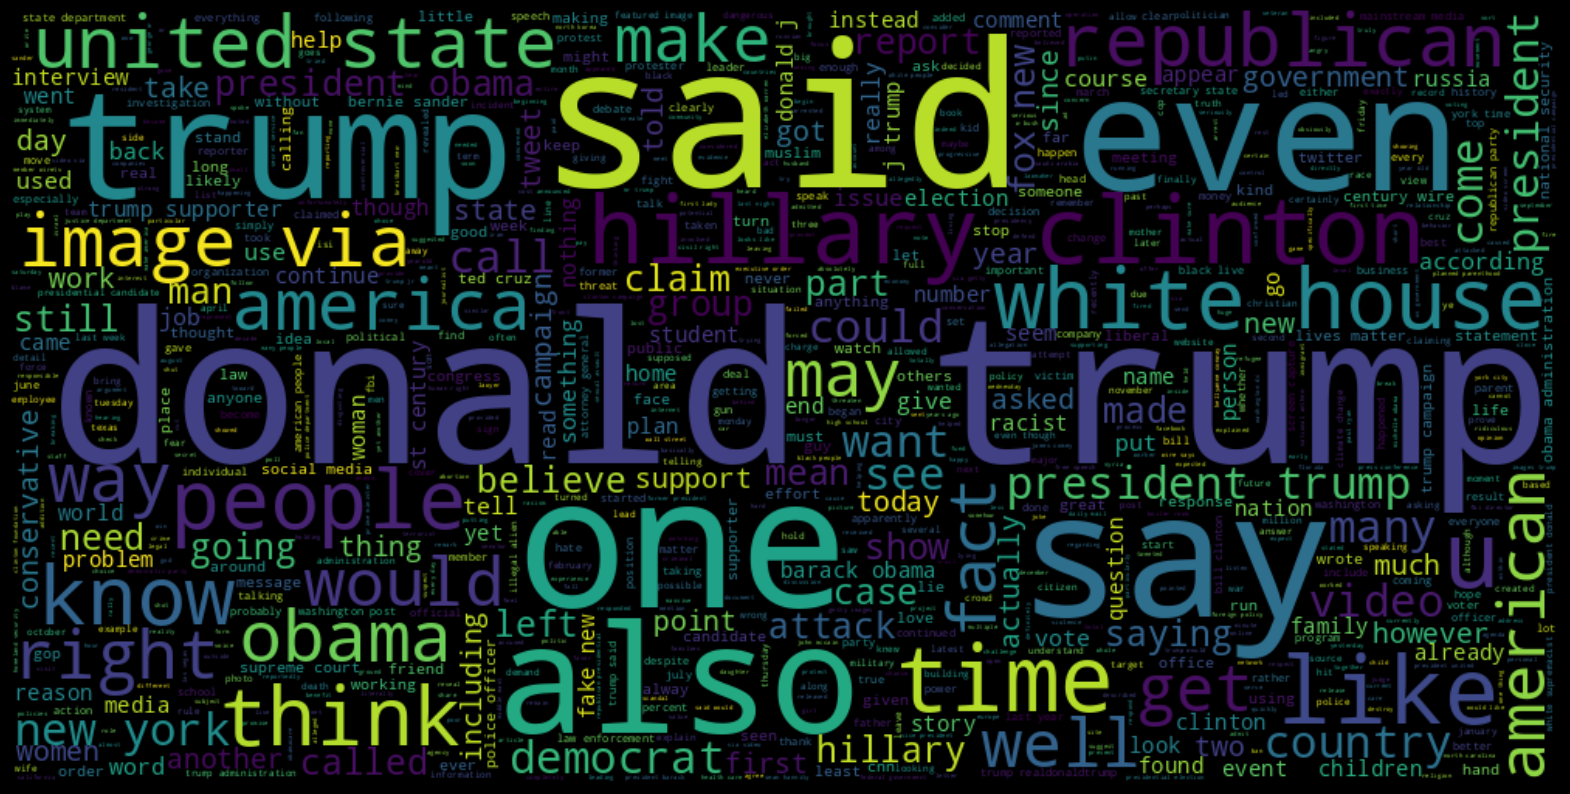

In [ ]:
text = " ".join(combined_data[combined_data.type == 0].text)

wc = WordCloud(max_words=1500, width=1000, height=500, stopwords=set(stopwords.words('english')))
wc.generate(text)

plt.figure(figsize=(20, 20), facecolor='k')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

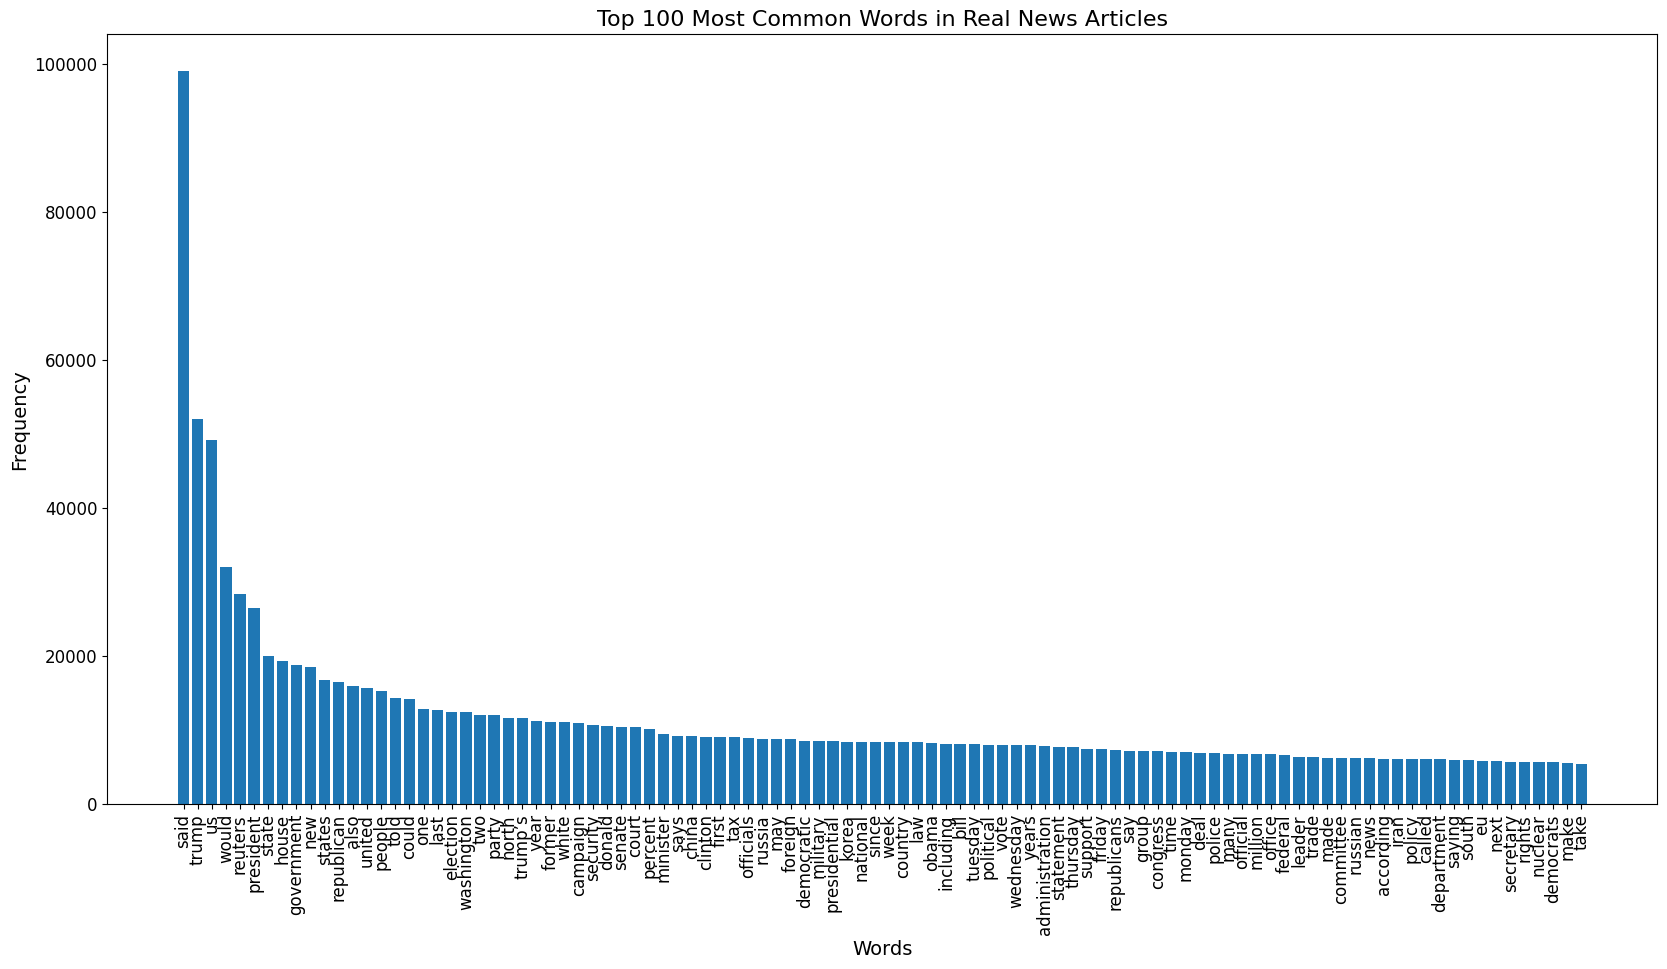

In [ ]:
real_words_count = Counter()

for row in combined_data.loc[combined_data['type'] == 1, 'text']:
    real_words_count.update(row.split())

real_common_words = real_words_count.most_common(100)

real_words = [word for word, count in real_common_words]
real_words_count = [count for word, count in real_common_words]

plt.figure(figsize=(20, 10))
plt.bar(real_words, real_words_count)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Top 100 Most Common Words in Real News Articles", fontsize=16)
plt.show()

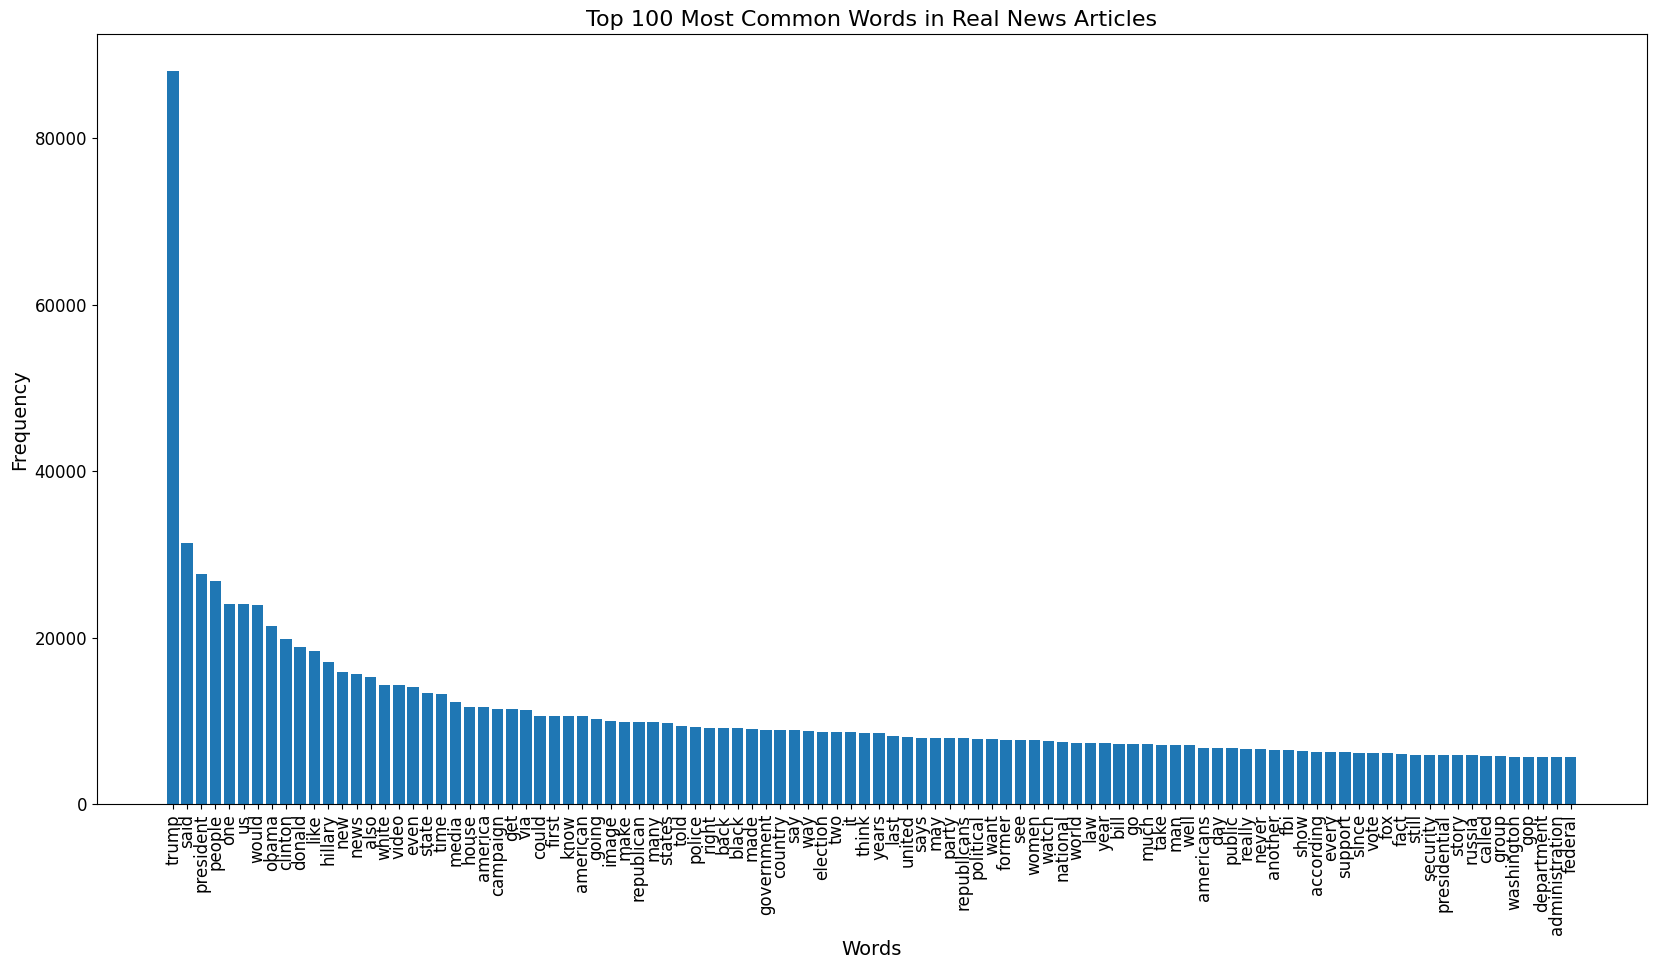

In [ ]:
fake_words_count = Counter()

for row in combined_data.loc[combined_data['type'] == 0, 'text']:
    fake_words_count.update(row.split())

fake_common_words = fake_words_count.most_common(100)

fake_words = [word for word, count in fake_common_words]
fake_words_count = [count for word, count in fake_common_words]

plt.figure(figsize=(20, 10))
plt.bar(fake_words, fake_words_count)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Top 100 Most Common Words in Real News Articles", fontsize=16)
plt.show()

###Tokenisation and model buliding

In [ ]:
y = combined_data['type'].values

In [ ]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
X = [d.split() for d in combined_data['text'].tolist()]

In [ ]:
print(X[0])

['us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'us', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'pay', 'tax', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'cbs’', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'even', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'keep', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'big', 'budget', '

In [ ]:
# Tokenising the model 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [ ]:
X

In [ ]:
tokenizer.word_index

In [ ]:
#embedding representation
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen,)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [ ]:
vocab_size

217221

In [ ]:
# Creating the model 
DIM = 100
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# Looking at summary of created model

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         21722100  
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,839,477
Trainable params: 117,377
Non-trainable params: 21,722,100
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

In [ ]:
model.fit(X_train, y_train, epochs=6)

Epoch 1/6
941/941 [==============================] - 32s 30ms/step - loss: 0.4718 - acc: 0.7766
Epoch 2/6
941/941 [==============================] - 29s 31ms/step - loss: 0.5850 - acc: 0.7109
Epoch 3/6
941/941 [==============================] - 29s 31ms/step - loss: 0.5926 - acc: 0.6922
Epoch 4/6
941/941 [==============================] - 29s 31ms/step - loss: 0.4908 - acc: 0.7585
Epoch 5/6
941/941 [==============================] - 30s 32ms/step - loss: 0.3606 - acc: 0.8362
Epoch 6/6
941/941 [==============================] - 29s 31ms/step - loss: 0.2812 - acc: 0.8820


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

464/464 [==============================] - 6s 13ms/step


In [ ]:
y_pred

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [ ]:
y_test

array([0, 0, 1, ..., 0, 1, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.8766281973408923

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      7728
           1       0.80      0.98      0.88      7089

    accuracy                           0.87     14817
   macro avg       0.89      0.88      0.87     14817
weighted avg       0.89      0.87      0.87     14817



In [ ]:
X_test

array([[    0,     0,     0, ...,   521,  2584,  2297],
       [    0,     0,     0, ...,  4913,     5,  2827],
       [    0,     0,     0, ...,   300,   668,   522],
       ...,
       [    0,     0,     0, ...,   494,   322,  1243],
       [    0,     0,     0, ...,   854, 50508,     2],
       [    0,     0,     0, ..., 70592,   108,  3816]], dtype=int32)

In [ ]:
confusion_matrix(y_test,y_pred)

TypeError: ignored

# Model testing and prediction

In [ ]:
def predictData(sourceData):
  sourceData = tokenizer.texts_to_sequences(sourceData)
  sourceData = pad_sequences(sourceData, maxlen=maxlen)
  final_value = (model.predict(sourceData)>=0.5).astype(int)

  if final_value == 0:
    print("FAKE NEWS")
  else:
    print("REAL NEWS")

In [ ]:
predictData(['A US official confirmed to CNN that Blome was summoned by Pakistan’s foreign ministry following Biden’s remarks. Those remarks frustrated US diplomats in the region, the US official said.'])

1/1 [==============================] - 0s 31ms/step
REAL NEWS


In [ ]:
predictData(['Sahara is in Asia'])

1/1 [==============================] - 0s 30ms/step
FAKE NEWS


In [ ]:
import pickle

In [ ]:
pickle.dump(X, open('X.pk1', 'wb'))


In [ ]:
pickle.dump(model,open('Sequential.pkl','wb'))

In [ ]:
vector_form=pickle.load(open('X.pk1','rb'))

In [ ]:
load_modal=pickle.load(open('Sequential.pkl','rb'))

In [ ]:
!pip install streamlit -q


In [ ]:
%%writefile webapp.py
import streamlit as st
st.write('# Hi Srujan')
st.write("#Hi Pradeep")

Writing webapp.py


In [ ]:
! pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("2OnBNpag6NiVTPVXpYfslzkgodC_67msLnqfekRG3AW8n4g2f")

# Start Streamlit server on port 80
!nohup streamlit run webapp.py --server.port 80 &

# Open a HTTP tunnel using ngrok
url = ngrok.connect(addr="80", proto="http")
print("Streamlit app can be accessed from:", url)



INFO:pyngrok.process:Updating authtoken for default "config_path" of "ngrok_path": /usr/local/lib/python3.9/dist-packages/pyngrok/bin/ngrok
2023-04-25 20:30:19.007 INFO    pyngrok.process: Updating authtoken for default "config_path" of "ngrok_path": /usr/local/lib/python3.9/dist-packages/pyngrok/bin/ngrok


nohup: appending output to 'nohup.out'


INFO:pyngrok.ngrok:Opening tunnel named: http-80-82524632-4204-49cc-a444-b34fb5c4c01d
2023-04-25 20:30:19.379 INFO    pyngrok.ngrok: Opening tunnel named: http-80-82524632-4204-49cc-a444-b34fb5c4c01d
INFO:pyngrok.process.ngrok:t=2023-04-25T20:30:19+0000 lvl=info msg=start pg=/api/tunnels id=42f889b1c3fb4c08
2023-04-25 20:30:19.388 INFO    pyngrok.process.ngrok: t=2023-04-25T20:30:19+0000 lvl=info msg=start pg=/api/tunnels id=42f889b1c3fb4c08
INFO:pyngrok.process.ngrok:t=2023-04-25T20:30:19+0000 lvl=info msg="started tunnel" obj=tunnels name=http-80-82524632-4204-49cc-a444-b34fb5c4c01d addr=http://localhost:80 url=https://8bd1-35-204-160-162.ngrok-free.app
2023-04-25 20:30:19.498 INFO    pyngrok.process.ngrok: t=2023-04-25T20:30:19+0000 lvl=info msg="started tunnel" obj=tunnels name=http-80-82524632-4204-49cc-a444-b34fb5c4c01d addr=http://localhost:80 url=https://8bd1-35-204-160-162.ngrok-free.app
INFO:pyngrok.ngrok:Opening tunnel named: http-8888-05ffb6a1-7f89-4dca-8bd3-018f6089e6e4
20

Streamlit app can be accessed from: NgrokTunnel: "https://8bd1-35-204-160-162.ngrok-free.app" -> "http://localhost:80"


INFO:pyngrok.process.ngrok:t=2023-04-25T20:30:19+0000 lvl=info msg="started tunnel" obj=tunnels name=http-8888-05ffb6a1-7f89-4dca-8bd3-018f6089e6e4 addr=http://localhost:8888 url=https://586d-35-204-160-162.ngrok-free.app


Jupyter notebook can be accessed from: NgrokTunnel: "https://586d-35-204-160-162.ngrok-free.app" -> "http://localhost:8888"


2023-04-25 20:30:19.624 INFO    pyngrok.process.ngrok: t=2023-04-25T20:30:19+0000 lvl=info msg="started tunnel" obj=tunnels name=http-8888-05ffb6a1-7f89-4dca-8bd3-018f6089e6e4 addr=http://localhost:8888 url=https://586d-35-204-160-162.ngrok-free.app
INFO:pyngrok.process.ngrok:t=2023-04-25T20:30:19+0000 lvl=info msg=end pg=/api/tunnels id=01eb65e978373a92 status=201 dur=112.356132ms
2023-04-25 20:30:19.636 INFO    pyngrok.process.ngrok: t=2023-04-25T20:30:19+0000 lvl=info msg=end pg=/api/tunnels id=01eb65e978373a92 status=201 dur=112.356132ms
